In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('classic')

# PLFS Workload
Clients write to different offsets of a single PLFS file. PLFS is backed by CephFS.

First, we show the namespace structure by plotting the number of files and directories.

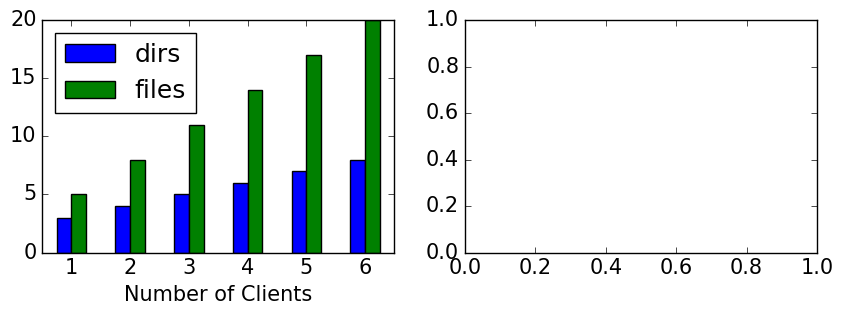

In [79]:
# for this workload, we tested clients all=5, half=3, one=1
clients = [1, 2, 3, 4, 5, 6]

# get and clean the data
df = pd.read_csv("results/files.txt", names=['clients', 'ts', 'latency', 'files'])
df0 = pd.read_csv("results/dirs.txt", names=['clients', 'ts', 'latency', 'dirs'])
df['dirs'] = df0['dirs']
df['dir_latency'] = df0['latency']

# graph namespace
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
df[['dirs', 'files']].plot.bar(ax=ax[0])
ax[0].set_xticklabels(clients, rotation=0)
ax[0].set_xlabel("Number of Clients")

# graph latencies
#df[['dir_latency', 'latency']].plot.bar(ax=ax[1])
#ax[1].set_xticklabels(clients, rotation=0)
#ax[1].set_xlabel("Number of Clients")

fig.savefig('results/namespace.png', dpi=400)
df_files = df

,handle_client_request,req_create,req_getattr,req_lookup,req_lookupname,req_mkdir,req_open,req_readdir,req_rename,req_rmdir,req_unlink
0,26.0,6.0,2.0,3.0,0.0,3.0,12.0,4.0,1.0,0.0,1.0
0,89.0,11.0,11.0,37.0,1.0,5.0,23.0,6.0,2.0,1.0,3.0
0,124.0,15.0,12.0,53.0,0.0,6.0,34.0,12.0,2.0,1.0,4.0
0,177.0,21.0,21.0,76.0,0.0,9.0,45.0,12.0,4.0,3.0,7.0
0,214.0,26.0,23.0,91.0,1.0,11.0,56.0,14.0,5.0,4.0,9.0
0,274.0,30.0,39.0,114.0,1.0,12.0,66.0,23.0,5.0,4.0,10.0


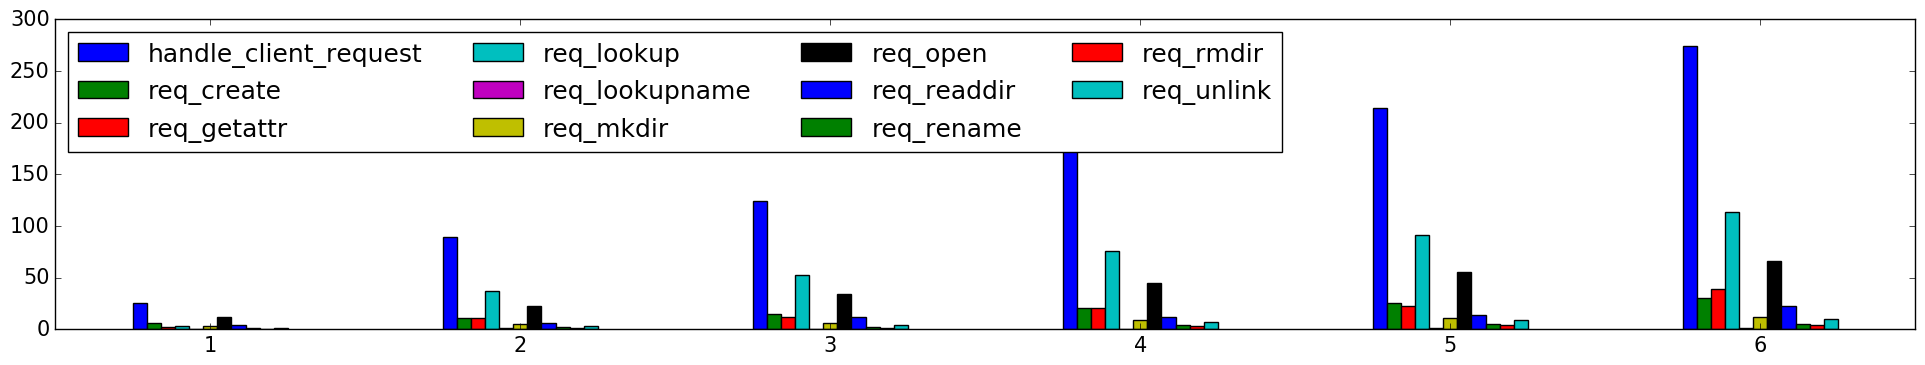

In [80]:
# get column headers
val = pd.DataFrame()
with open ("results/perfdump_6_after") as f:
    data = json.load(f)
    val = json_normalize(data['mds_server'])
df = pd.DataFrame(columns=list(val))

# read in the data
for i in ["1", "2", "3", "4", "5", "6"]:
    with open ("results/perfdump_" + str(i) + "_after") as f:
        data = json.load(f)
        val = json_normalize(data['mds_server'])
    with open ("results/perfdump_" + str(i) + "_before") as f:
        data = json.load(f)
        val = val - json_normalize(data['mds_server'])
    df = df.append(val)
#df = df.set_index([[0, 1, 2, 3, 4, 5]])

# delete things that aren't requests
del df['dispatch_client_request']
del df['dispatch_server_request']
del df['handle_client_session']
del df['handle_slave_request']
for col in list(df):
    if df[col].sum() == 0:
        del df[col]

fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, figsize=(24, 4))
ax.set_xticklabels(clients, rotation=0)
ax.legend(ncol=4, loc='upper left')
#fig.savefig('results/namespace-requests.png', dpi=400)
df

# RPC Amplication

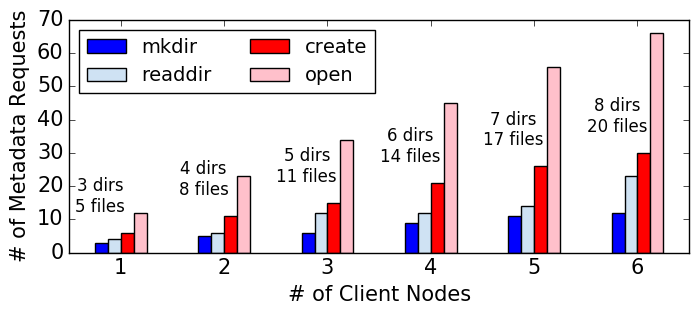

In [109]:
# get column headers
val = pd.DataFrame()
with open ("results/perfdump_6_after") as f:
    data = json.load(f)
    val = json_normalize(data['mds_server'])
df = pd.DataFrame(columns=list(val))

# read in the data
for i in ["1", "2", "3", "4", "5", "6"]:
    with open ("results/perfdump_" + str(i) + "_after") as f:
        data = json.load(f)
        val = json_normalize(data['mds_server'])
    with open ("results/perfdump_" + str(i) + "_before") as f:
        data = json.load(f)
        val = val - json_normalize(data['mds_server'])
    df = df.append(val)
#df = df.set_index([[0, 1, 2, 3, 4, 5]])

# delete things that aren't requests
del df['dispatch_client_request']
del df['dispatch_server_request']
del df['handle_client_session']
del df['handle_slave_request']
for col in list(df):
    if df[col].sum() == 0:
        del df[col]
cols = []
for c in df.columns:
    if 'req_' in c: cols.append(c.split('_')[1])
    else: cols.append(c)   
df.columns = cols

#print df['req_lookup']/df['req_create']
#print df['req_open']/df['req_create']
#x = df['req_open']#/[1, 2, 3, 4, 5, 6]
#print df['req_create']/clients[::-1]
#fig, ax = plt.subplots(1, 1)
font = {'size'   : 15}; matplotlib.rc('font', **font)
args = {'width': 1, 'capsize': 4, 'ecolor': 'black'}
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df[['mkdir', 'readdir', 'create', 'open']].plot.bar(ax=ax, color=['blue', '#cfe2f3', 'red', 'pink'])
ax.set_ylabel("# of Metadata Requests")
ax.set_xticklabels(clients, rotation=0)
ax.set_xlabel("# of Client Nodes")
ax.legend(ncol=2, loc='upper left', fontsize=14)
ax.set_ylim(0)

def annotate_overhead(ax, df, args, i=0, inc=1):
    args = {'fontsize': 12, 'horizontalalignment': 'center'}
    top = df['open']
    print top.max()
    #ax.annotate(str(top) + "", xy=(i, top), xytext=(i, top), **args)
    i += 1
args = {'fontsize': 12, 'horizontalalignment': 'center'}
i = 0
for top in df['create']:
    f = str(df_files['files'][i]) + " files\n"
    d = str(df_files['dirs'][i]) + " dirs\n"
    ax.annotate(d + f, xy=(i-0.2, top), xytext=(i-0.2, top), **args)
    i += 1
fig.savefig('../../paper/figures/plfs_problem.png', dpi=300, bbox_inches='tight')

# Normalized to Number of Requests

In [5]:
# normalize
for metric in list(df):
    if metric != 'handle_client_request':
        df[metric] = df[metric]/df['handle_client_request']

fig, ax = plt.subplots(1, 1)
df.plot.bar(ax=ax, figsize=(24, 4))
ax.set_xticklabels(clients, rotation=0)
ax.legend(ncol=6, loc='upper right')
ax.set_ylim(0, 1)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
fig.savefig('results/namespace-requests-percent.png', dpi=400)
df

KeyError: 'handle_client_request'